In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio as rio
from rasterio import plot
import rasterio.mask
from pathlib import Path
from skimage import exposure

---
# NBR = (B8A - B12) / (B8A + B12)
---

In [2]:
# Load polygon vector
boundsdata = r'../data/mizieb.geojson'
region = gpd.read_file(boundsdata)
region

nReserve_proj = region.to_crs({'init': 'epsg:32633'})

p = ('../data/selecteddata/Mizieb')

C:\Users\MCAST\anaconda3\envs\remsen\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


 Mizieb
--- Mizieb (23-05-2019)
------ AUX_DATA
------ DATASTRIP
--------- DS_SGS__20190523T115415_S20190523T095443
------------ QI_DATA
------ GRANULE
--------- L1C_T33SVV_A011545_20190523T095443
------------ AUX_DATA
------------ IMG_DATA
--------------- T33SVV_20190523T095039_B01.jp2
--------------- T33SVV_20190523T095039_B02.jp2
--------------- T33SVV_20190523T095039_B03.jp2
--------------- T33SVV_20190523T095039_B04.jp2
--------------- T33SVV_20190523T095039_B05.jp2
--------------- T33SVV_20190523T095039_B06.jp2
--------------- T33SVV_20190523T095039_B07.jp2
--------------- T33SVV_20190523T095039_B08.jp2
--------------- T33SVV_20190523T095039_B09.jp2
--------------- T33SVV_20190523T095039_B10.jp2
--------------- T33SVV_20190523T095039_B11.jp2
--------------- T33SVV_20190523T095039_B12.jp2
--------------- T33SVV_20190523T095039_B8A.jp2
--------------- T33SVV_20190523T095039_TCI.jp2
-0.7460403046437959
1.0
float64


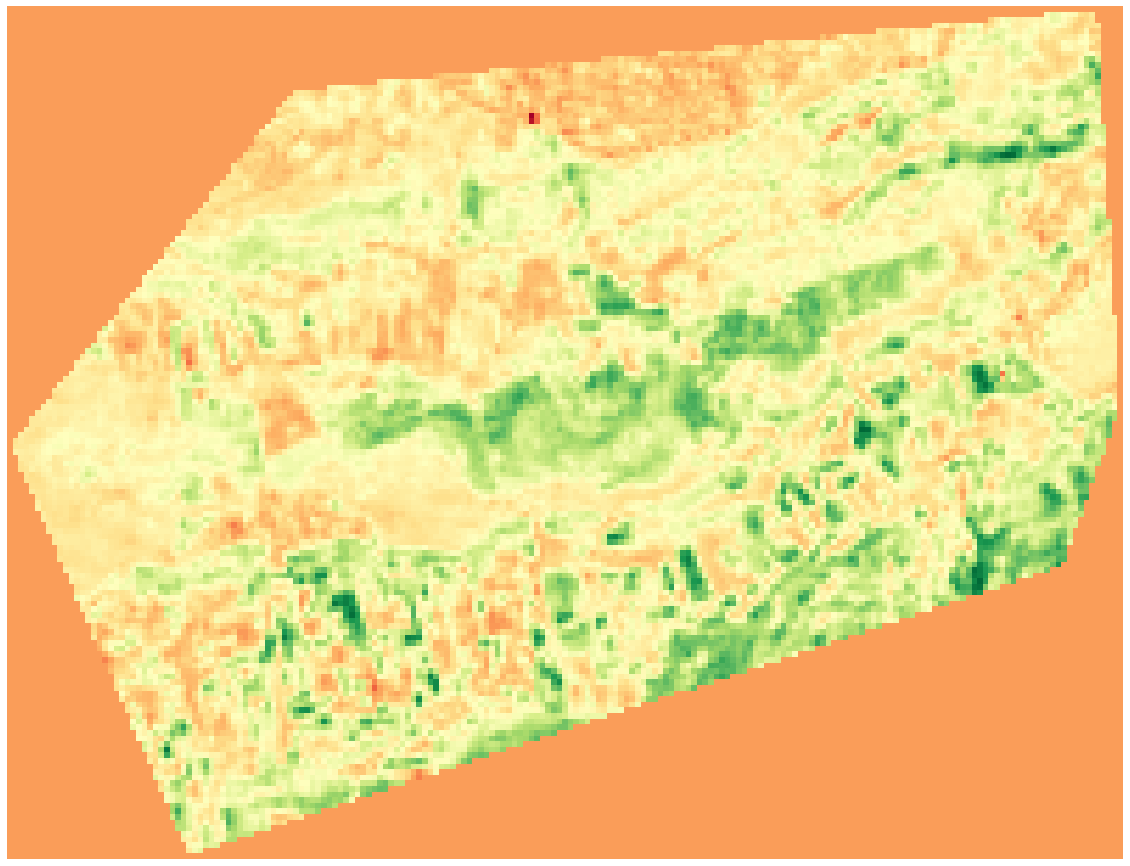

Min NBR: -0.25465446513095613
Max NBR: 0.6749956918835085
------------ QI_DATA
------ HTML
------ rep_info
--- Mizieb (27-06-2019)
------ AUX_DATA
------ DATASTRIP
--------- DS_SGS__20190627T133421_S20190627T095541
------------ QI_DATA
------ GRANULE
--------- L1C_T33SVV_A020954_20190627T095541
------------ AUX_DATA
------------ IMG_DATA
--------------- T33SVV_20190627T095031_B01.jp2
--------------- T33SVV_20190627T095031_B02.jp2
--------------- T33SVV_20190627T095031_B03.jp2
--------------- T33SVV_20190627T095031_B04.jp2
--------------- T33SVV_20190627T095031_B05.jp2
--------------- T33SVV_20190627T095031_B06.jp2
--------------- T33SVV_20190627T095031_B07.jp2
--------------- T33SVV_20190627T095031_B08.jp2
--------------- T33SVV_20190627T095031_B09.jp2
--------------- T33SVV_20190627T095031_B10.jp2
--------------- T33SVV_20190627T095031_B11.jp2
--------------- T33SVV_20190627T095031_B12.jp2
--------------- T33SVV_20190627T095031_B8A.jp2
--------------- T33SVV_20190627T095031_TCI.jp2
-1

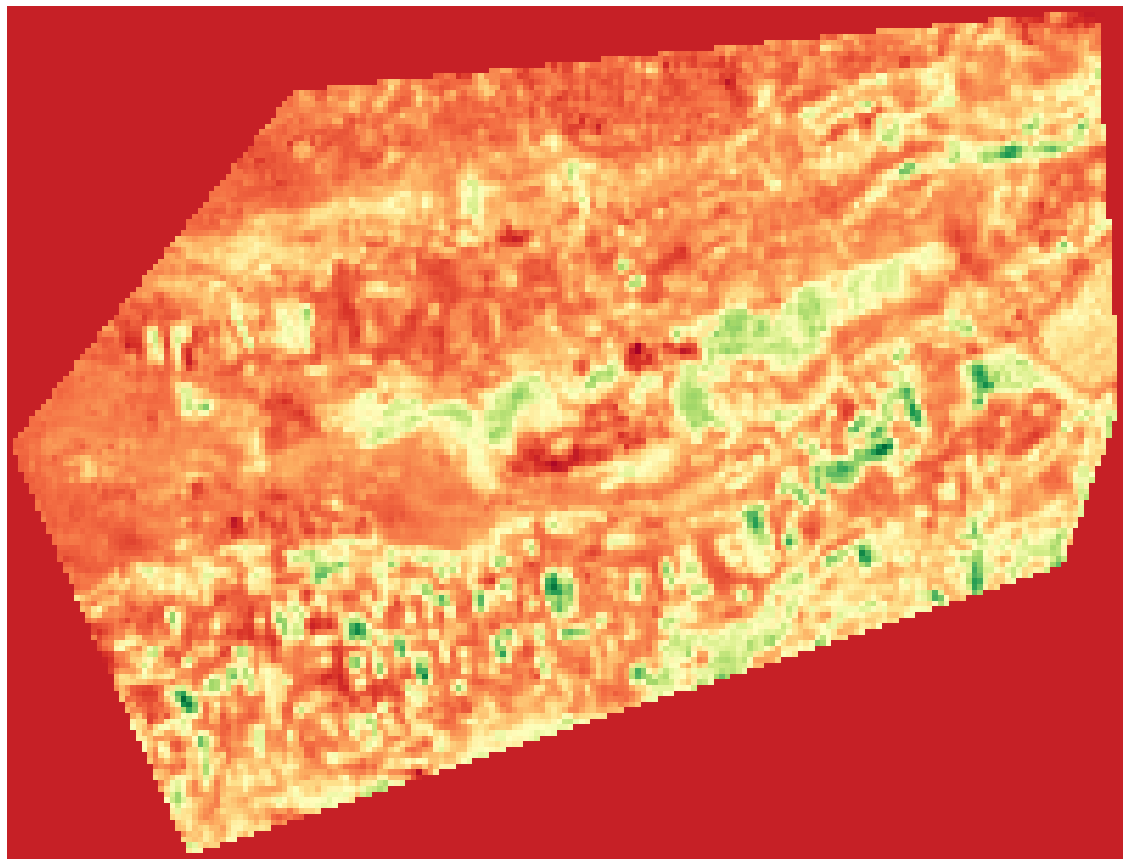

Min NBR: -0.05059203444564048
Max NBR: 0.7062339880444065
------------ QI_DATA
------ HTML
------ rep_info


In [3]:
path = Path(p)
k=0
# traverse root directory, and list directories as dirs and files as files
for root, dirs, files in os.walk(p):
    path = root.split(os.sep)
    print((len(path) - 1) * '---', os.path.basename(root))


    #print(path[:6])

    if os.path.basename(root) == 'IMG_DATA':
        k+=1
        for file in files:
            print(len(path) * '---', file)

            if 'B8A' in file: b8A = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #NIR

            if 'B12' in file: b12 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #SWIR

            if 'TCI' in file: tci = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG')

        # read Red(b4) and NIR(b8) as arrays
        nir = b8A.read()
        swir = b12.read()

        tci_cropped, cropped_transform = rio.mask.mask(tci, nReserve_proj.geometry,crop=True)

        # Do not display error when divided by zero
        np.seterr(divide='ignore', invalid='ignore')

        # Calculate NBR
        nbr = (nir.astype(float)-swir.astype(float))/(nir+swir)

        #Print NBR min and max
        print(np.nanmin(nbr))
        print(np.nanmax(nbr))

        # get the dtype of our NBR array:
        nbr_dtype = nbr.dtype
        print(nbr_dtype)

        # Write the NBR image
        meta = b8A.meta
        meta.update(driver='GTiff')
        meta.update(dtype=rasterio.float64)

        with rasterio.open('../Output/NBR.tif', 'w', **meta) as dst:
            dst.write(nbr)

        with rio.open("../Output/NBR.tif") as src:
            out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
            out_meta = src.meta.copy()
            out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})

        with rasterio.open('../Output/NBR_cropped.tif', 'w', **meta) as dst:
            dst.write(out_image)

        fig = plt.figure(figsize=(20,16))
        ax=fig.add_subplot(1,1,1)
        plt.axis('off')
        plot.show(out_image, cmap='RdYlGn')

        #Print NDVI min and max
        print('Min NBR:', np.nanmin(out_image))
        print('Max NBR:', np.nanmax(out_image))

---
# RGB (2,3,4)
---

 Mizieb
--- Mizieb (23-05-2019)
------ AUX_DATA
------ DATASTRIP
--------- DS_SGS__20190523T115415_S20190523T095443
------------ QI_DATA
------ GRANULE
--------- L1C_T33SVV_A011545_20190523T095443
------------ AUX_DATA
------------ IMG_DATA
--------------- T33SVV_20190523T095039_B01.jp2
--------------- T33SVV_20190523T095039_B02.jp2
--------------- T33SVV_20190523T095039_B03.jp2
--------------- T33SVV_20190523T095039_B04.jp2
--------------- T33SVV_20190523T095039_B05.jp2
--------------- T33SVV_20190523T095039_B06.jp2
--------------- T33SVV_20190523T095039_B07.jp2
--------------- T33SVV_20190523T095039_B08.jp2
--------------- T33SVV_20190523T095039_B09.jp2
--------------- T33SVV_20190523T095039_B10.jp2
--------------- T33SVV_20190523T095039_B11.jp2
--------------- T33SVV_20190523T095039_B12.jp2
--------------- T33SVV_20190523T095039_B8A.jp2
--------------- T33SVV_20190523T095039_TCI.jp2
1
10980
10980
uint16
EPSG:32633
| 10.00, 0.00, 399960.00|
| 0.00,-10.00, 4000020.00|
| 0.00, 0.00, 1.

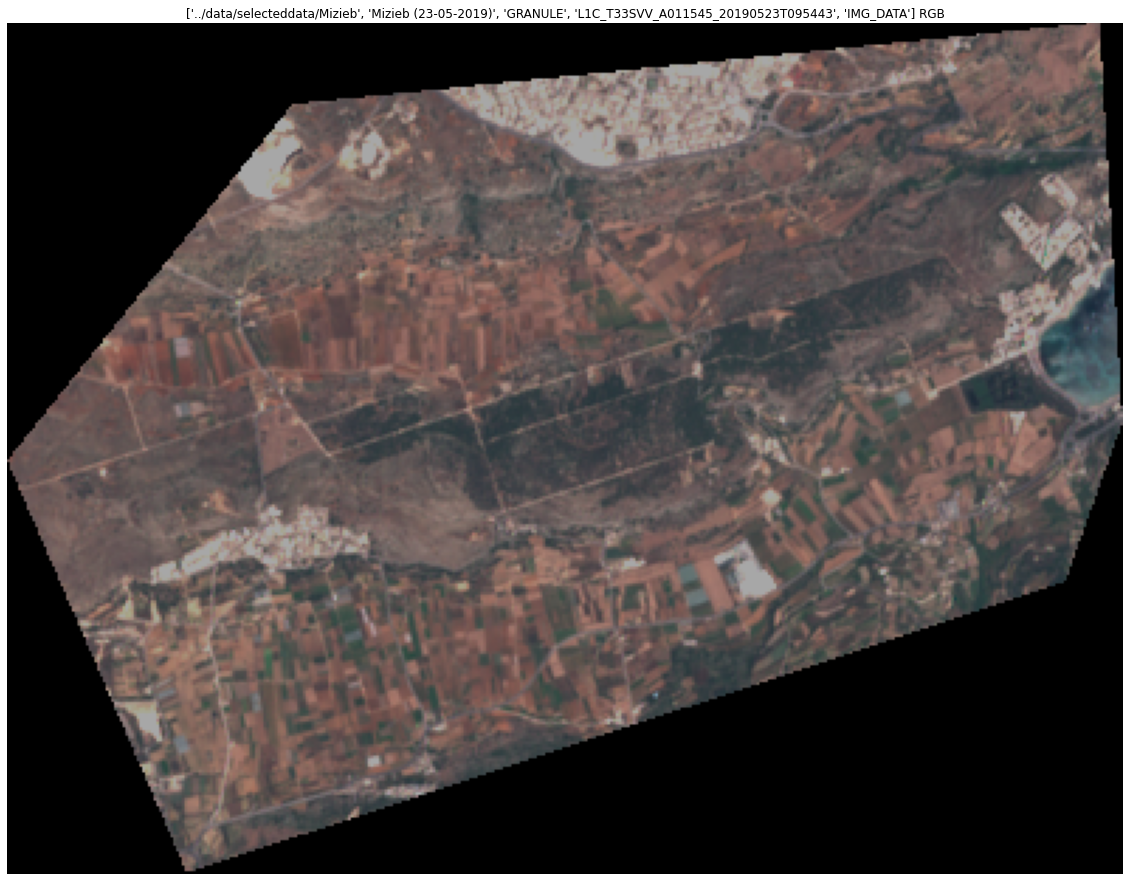

------------ QI_DATA
------ HTML
------ rep_info
--- Mizieb (27-06-2019)
------ AUX_DATA
------ DATASTRIP
--------- DS_SGS__20190627T133421_S20190627T095541
------------ QI_DATA
------ GRANULE
--------- L1C_T33SVV_A020954_20190627T095541
------------ AUX_DATA
------------ IMG_DATA
--------------- T33SVV_20190627T095031_B01.jp2
--------------- T33SVV_20190627T095031_B02.jp2
--------------- T33SVV_20190627T095031_B03.jp2
--------------- T33SVV_20190627T095031_B04.jp2
--------------- T33SVV_20190627T095031_B05.jp2
--------------- T33SVV_20190627T095031_B06.jp2
--------------- T33SVV_20190627T095031_B07.jp2
--------------- T33SVV_20190627T095031_B08.jp2
--------------- T33SVV_20190627T095031_B09.jp2
--------------- T33SVV_20190627T095031_B10.jp2
--------------- T33SVV_20190627T095031_B11.jp2
--------------- T33SVV_20190627T095031_B12.jp2
--------------- T33SVV_20190627T095031_B8A.jp2
--------------- T33SVV_20190627T095031_TCI.jp2
1
10980
10980
uint16
EPSG:32633
| 10.00, 0.00, 399960.00|
| 

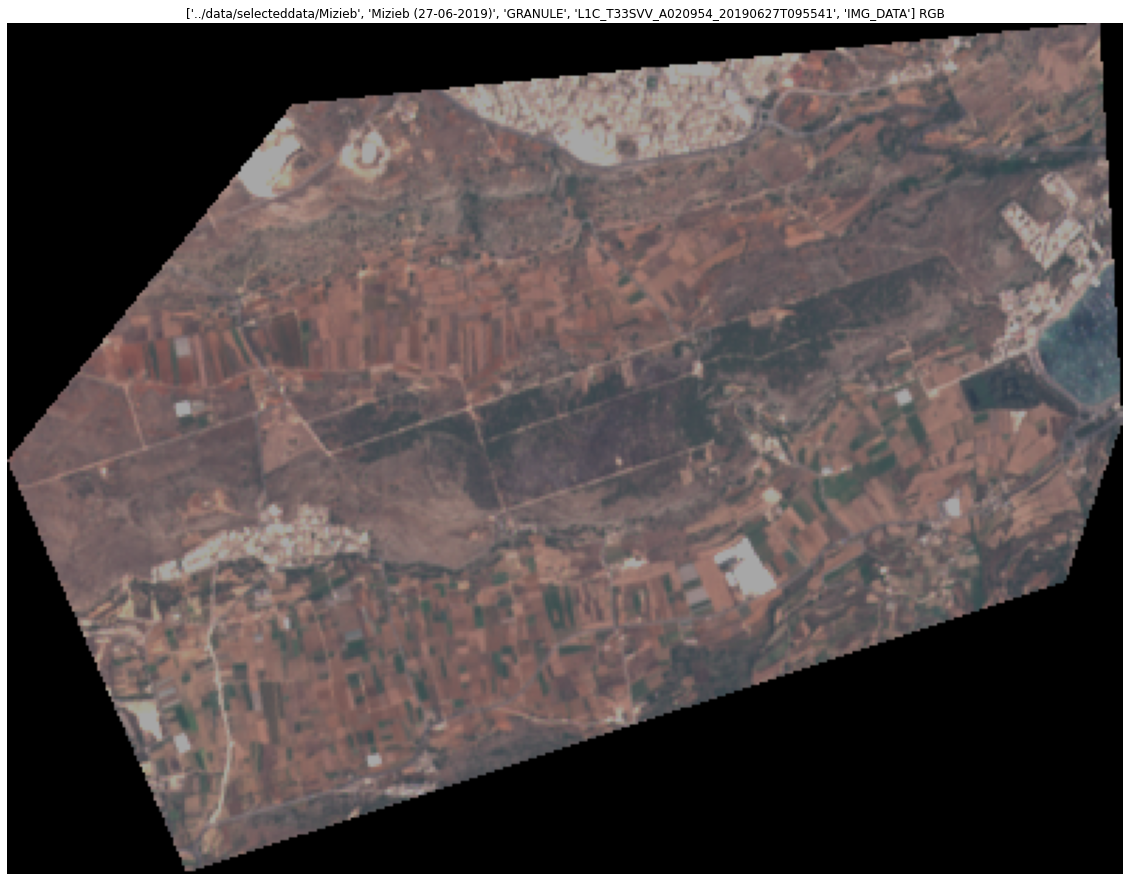

------------ QI_DATA
------ HTML
------ rep_info


In [4]:
path = Path(p)
k=0
# traverse root directory, and list directories as dirs and files as files
for root, dirs, files in os.walk(p):
    path = root.split(os.sep)
    print((len(path) - 1) * '---', os.path.basename(root))


    #print(path[:6])

    if os.path.basename(root) == 'IMG_DATA':
        k+=1
        for file in files:
            print(len(path) * '---', file)

            if 'B02' in file: band2 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #blue
            #if 'B02_20m' in file: band2 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #blue

            if 'B03' in file: band3 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #green
            #if 'B03_20m' in file: band3 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #green

            if 'B04' in file: band4 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #red
            #if 'B04_20m' in file: band4 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #red

            #if 'B08' in file: band8 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #nir

        if band2 is not None:
            #number of raster bands
            print(band2.count)
            #number of raster columns
            print(band2.width)
            #number of raster rows
            print(band2.height)

            #type of raster byte
            print(band2.dtypes[0])
            #raster sytem of reference
            print(band2.crs)
            #raster transform parameters
            print(band2.transform)

            #export true color image
            trueColor = rasterio.open('../Output/CACHE/SentinelTemp.tiff','w',driver='Gtiff',
                                     width=band4.width, height=band4.height,
                                     count=3,
                                     crs=band4.crs,
                                     transform=band2.transform,
                                     dtype=band2.dtypes[0]
                                     )
            trueColor.write(band2.read(1),1) #blue
            trueColor.write(band3.read(1),2) #green
            trueColor.write(band4.read(1),3) #red
            trueColor.close()

            with rio.open("../Output/CACHE/SentinelTemp.tiff") as src:
                out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
                out_meta = src.meta.copy()
                out_meta.update({"driver": "GTiff",
                             "height": out_image.shape[1],
                             "width": out_image.shape[2],
                             "transform": out_transform,
                             "dtype": "uint16"})




            # Rescale the image (divide by 10000 to convert to [0:1] reflectance
            image = np.array(out_image[[2,1,0], :, :])
            p2, p98 = np.percentile(image, (2,98))
            image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

            rgb = np.array(image.transpose(1,2,0))

            #Plot and save image with Matplotlib
            fig = plt.figure(figsize=(20,16))
            ax=fig.add_subplot(1,1,1)
            ax.set_title(str(path) +' RGB')
            #fig.suptitle("BOLD TITLE")
            plt.axis('off')
            plt.imshow(rgb)

            #Save scaled reflectance image
            # Call 'savefig' to save this plot to an image file
            file_to_save = 'Mizieb_Rendered_' + str(k).zfill(3) +'.png'
            plt.savefig(os.path.join('../Output/PROCESSED', file_to_save), bbox_inches='tight', transparent=True, pad_inches=0)
            plt.show()